In [17]:
# Preprocessing images and labels for training
# Author: Chengchao Xu
# Date: 2025-03-11

# virtual environment: mini-proj
# "conda activate mini-proj"

# libraries
import os
import numpy as np
from skimage import feature, io, color, exposure, filters
import matplotlib.pyplot as plt
import tqdm 


Original image shape: (996, 1500)


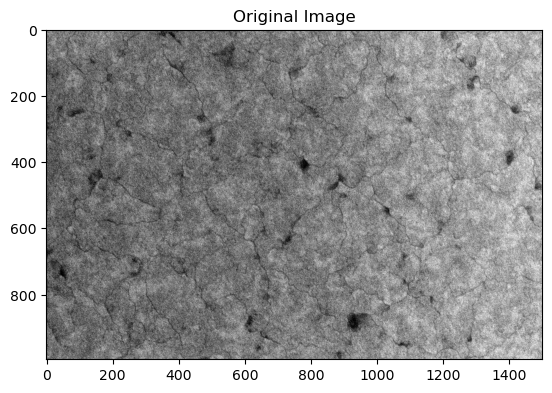

In [33]:
# Load and preprocess image
image = io.imread('train_image.tif')
# Convert to grayscale if necessary
if len(image.shape) > 2:
    image = color.rgb2gray(image)
print(f"Original image shape: {image.shape}")

# display the image
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Optional
from skimage.morphology import disk, white_tophat
selem = disk(50)  # Size controls how large of background variations to remove
image = white_tophat(image, selem)
# Alternative: background subtraction using gaussian blur
# background = filters.gaussian(image, sigma=50)
# image_no_bg = image - background

# Step 2: Enhance contrast
# Using Contrast Limited Adaptive Histogram Equalization (CLAHE)
# image_enhanced = exposure.equalize_adapthist(image)
# Alternative: Simple contrast stretching
image_enhanced = exposure.rescale_intensity(image)


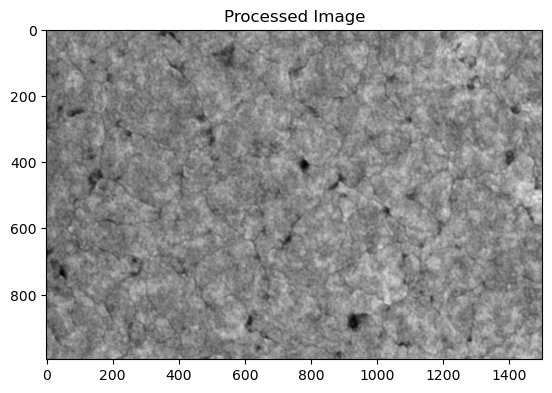

In [34]:

# Step 3: Gaussian blur to denoise
image_denoised = filters.gaussian(image_enhanced, sigma=2)

# Display the processed image
image_processed = image_denoised
plt.figure()
plt.imshow(image_processed, cmap='gray')
plt.title('Processed Image')

# Set scale factor, measured using imageJ
SCALE_FACTOR = 0.603 # pixel/nm

Feature shape: (996, 1500, 16)


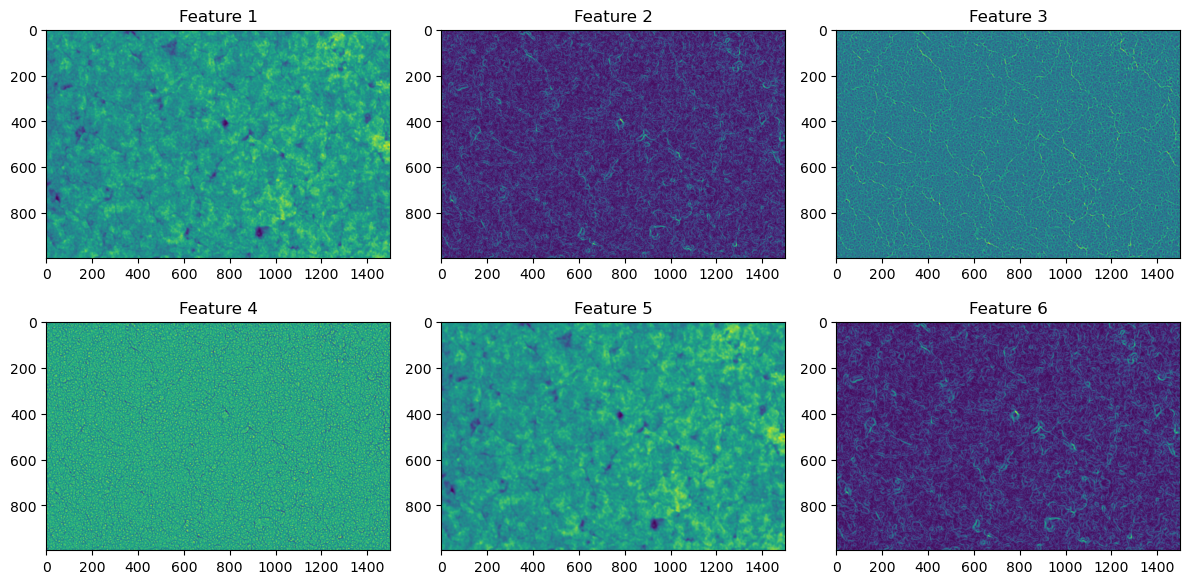

In [27]:
# skimage feature extraction
features = feature.multiscale_basic_features(
    image=image_processed,
    intensity=True,
    texture=True,
    edges=True,
    sigma_min=1,
    sigma_max=10,
    channel_axis=None # no color channel
)
print(f"Feature shape: {features.shape}")

# visualize six features
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[:, :, i], cmap='viridis') # false color
    ax.set_title(f"Feature {i+1}")
plt.tight_layout()
plt.show()



Label shape: (996, 1500)


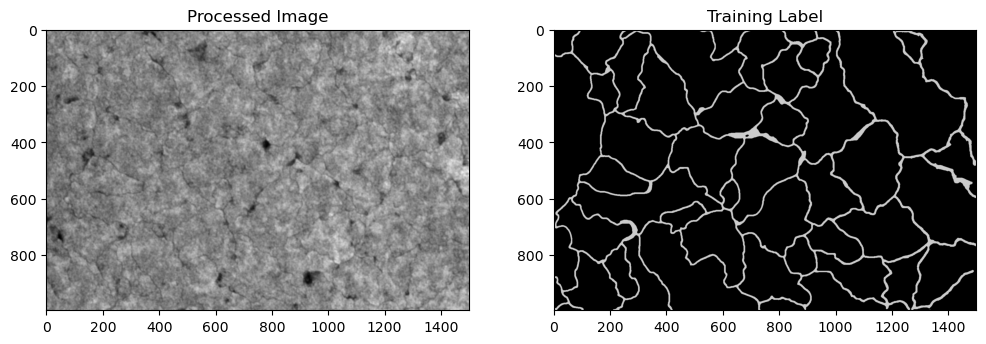

In [28]:
binary_label = io.imread('train_labels.tif')
print(f"Label shape: {binary_label.shape}")

# convert to training label
train_label = np.zeros_like(binary_label, dtype=np.uint8)
train_label[binary_label == 0] = 0 # Black background = grains
train_label[binary_label == 255] = 1 # White = grain boundaries

# display the label and original image
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_processed, cmap='gray')
plt.title('Processed Image')

plt.subplot(122)
plt.imshow(train_label, cmap='nipy_spectral')
plt.title('Training Label')
plt.show()

In [29]:

from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier

# This is a binary pixel classifier

# First, we need to deal with imbalanced data
uniqe, counts = np.unique(train_label, return_counts=True)
print(f"Unique labels percentage:")
for i, c in zip(uniqe, counts):
    print(f"Label {i}: {c/np.sum(counts)*100:.2f}%")

# Fix the class_weight parameter syntax
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # This needs to be a named parameter
    classes=np.unique(train_label),
    y=train_label.flatten()
)
class_weight_dict = {i: w for i, w in zip(uniqe, class_weights)}
print(f"Class weights:", class_weight_dict)


Unique labels percentage:
Label 0: 91.63%
Label 1: 8.37%
Class weights: {0: 0.545668908267724, 1: 5.974183848110174}


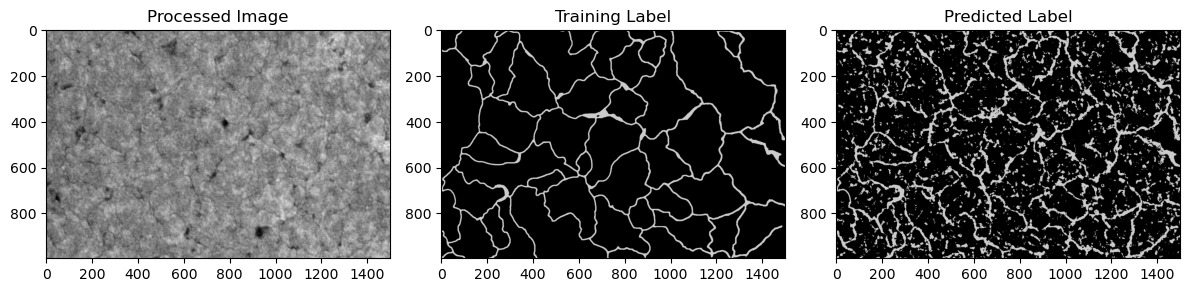

In [30]:
# create a random forest classifier
pixel_classifier = RandomForestClassifier(
    n_estimators=50, # Number of trees
    n_jobs=-1, # Use all available cores
    max_depth=15, # Limit the depth of the trees
    min_samples_split=3, # Minimum samples required to split a node
    class_weight=class_weight_dict # Use the computed class weights
)

# train the classifier
X = features.reshape(-1, features.shape[2])
y = train_label.flatten()
pixel_classifier.fit(X, y)

# make predictions
y_pred = pixel_classifier.predict(X)
y_pred = y_pred.reshape(train_label.shape)

# display the prediction
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(image_processed, cmap='gray')
plt.title('Processed Image')

plt.subplot(132)
plt.imshow(train_label, cmap='nipy_spectral')
plt.title('Training Label')

plt.subplot(133)
plt.imshow(y_pred, cmap='nipy_spectral')
plt.title('Predicted Label')

plt.tight_layout()
plt.show()


In [35]:
# save the model
import joblib
joblib.dump(pixel_classifier, 'pixel_classifier.joblib')
# save the processed image
io.imsave('processed_train_image.tif', image_processed)
